# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD

In [2]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = 'kaggle/input/the-nature-conservancy-fisheries-monitoring/train'

def load_boxes():
    boxes = dict()
    for path in glob('kaggle/input/fish-boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                annotation['class'] = os.path.split(os.path.dirname(annotation['filename']))[1]
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

In [3]:
glob('kaggle/input/fish-boxes/*.json')

['kaggle/input/fish-boxes\\alb_labels.json',
 'kaggle/input/fish-boxes\\bet_labels.json',
 'kaggle/input/fish-boxes\\dol_labels.json',
 'kaggle/input/fish-boxes\\lag_labels.json',
 'kaggle/input/fish-boxes\\shark_labels.json',
 'kaggle/input/fish-boxes\\yft_labels.json']

In [4]:
boxes = load_boxes()  # разметка детекций

In [5]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


In [6]:
labels = sorted(list(map(str.upper, list(boxes.keys()))) + ['NoF','OTHER'])
print(labels)
print([int(i == 'SHARK') for i in labels], type([int(i == 'SHARK') for i in labels]))

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
[0, 0, 0, 0, 0, 0, 1, 0] <class 'list'>


In [7]:
boxes['shark'][0]

{'annotations': [{'class': 'rect',
   'height': 150.0000000000004,
   'width': 66.00000000000011,
   'x': 571.0000000000014,
   'y': 427.000000000001}],
 'class': 'SHARK',
 'filename': 'kaggle/input/the-nature-conservancy-fisheries-monitoring/train\\SHARK\\img_07860.jpg'}

In [8]:
draw_boxes(boxes['shark'][0])

array([[[254, 254, 252],
        [253, 253, 251],
        [253, 254, 255],
        ...,
        [  0,  16,   3],
        [  0,  16,   3],
        [  0,  16,   3]],

       [[255, 255, 255],
        [253, 255, 254],
        [254, 255, 255],
        ...,
        [  0,  16,   3],
        [  0,  16,   3],
        [  0,  16,   3]],

       [[252, 253, 255],
        [252, 254, 253],
        [253, 255, 254],
        ...,
        [  0,  16,   3],
        [  0,  16,   3],
        [  0,  16,   3]],

       ...,

       [[ 45,  87,  41],
        [ 44,  86,  40],
        [ 45,  87,  41],
        ...,
        [  5,  29,   5],
        [  6,  30,   6],
        [  6,  30,   6]],

       [[ 45,  87,  41],
        [ 45,  87,  41],
        [ 45,  87,  41],
        ...,
        [  5,  29,   5],
        [  6,  30,   6],
        [  6,  30,   6]],

       [[ 44,  86,  40],
        [ 45,  87,  41],
        [ 45,  87,  41],
        ...,
        [  5,  29,   5],
        [  6,  30,   6],
        [  6,  30,   6]]

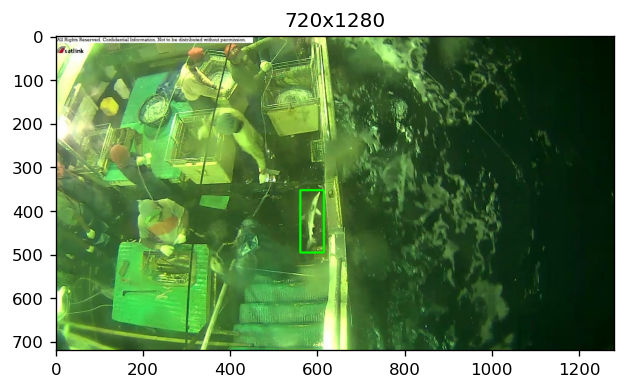

In [9]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['shark'][1])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

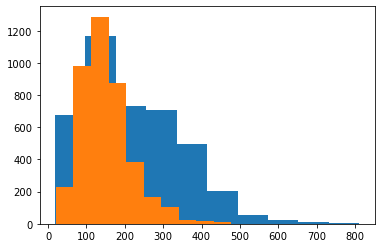

In [10]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

In [11]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

In [12]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [13]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5+8), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    #print(annotation)
    y = annotation['class']
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]
        #print(y, labels, [int(i == y) for i in labels])
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh] + [int(i == y) for i in labels]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col][:5]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

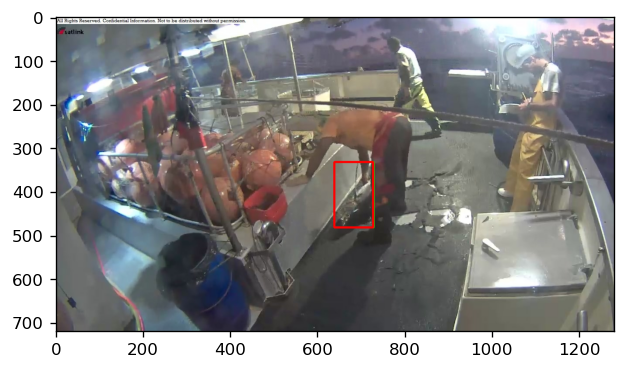

In [14]:
example = boxes['alb'][5]
#print(example)
encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))
#print(encoded)
decoded = decode_prediction(encoded, conf_thr=0.5)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:10]))

In [15]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss

In [16]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                #print(encode_anchors(boxes[j], img_shape))
                #print(boxes[j]['class'])
                y.append([int(boxes[j]['class']==c) for c in labels]) #encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

In [17]:
output = keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
#output = keras.layers.Conv2D(5, kernel_size=(1, 1), activation='linear', kernel_regularizer='l2')(output)

output = keras.layers.Flatten()(output)

output = keras.layers.Dense(64, activation='relu')(output)
output = keras.layers.Dropout(0.5)(output)
output = keras.layers.BatchNormalization()(output)
output = keras.layers.Dense(8, activation='softmax')(output)

model = keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0     

In [18]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
# model.compile(optimizer=adam, loss=total_loss, metrics= [confidence_loss])
#model.compile(loss='sparse_categorical_crossentropy', optimizer=adam)#, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=adam)
#, metrics=['accuracy']

#sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=False)
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [19]:
int(sum(map(len, boxes.values()), 0))

3013

In [20]:
batch_size = 10
steps_per_epoch = int(sum(map(len, boxes.values()), 0) / batch_size)

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1,
                    callbacks=[checkpoint]
                   )
model.save('model.hdf5')

'''model.fit(X, y, batch_size=batch_size, epoch=10,
              validation_split=0.2, verbose=1)'''

D:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


ResourceExhaustedError:  OOM when allocating tensor with shape[10,750,1200,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node model/block1_conv1/Relu (defined at <ipython-input-20-2a3ad3360afa>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1778]

Function call stack:
train_function


In [ ]:
example = boxes['lag'][17]

img_shape, sample_img = load_img('D:/Учеба/Lern DS of Netology/Курс ML 4 CV и нейросетки/07_Задачи детекции и сегментации/data/fish/test_stg1/img_02811.jpg') #example['filename'])
pred = model.predict(np.array([sample_img,]))[0]

In [ ]:
img_shape, ['lag00']+list(pred)

In [ ]:
'''example = boxes['lag'][17]

_, sample_img = load_img(example['filename'])
pred = model.predict(np.array([sample_img,]))[0]

decoded = decode_prediction(pred, conf_thr=0.)
decoded = sorted(decoded, key=lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(example, decoded[:3], (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));'''

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0
import csv
TEST_PREFIX = '/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg1/'
TEST_PREFIX2 = '/kaggle/input/the-nature-conservancy-fisheries-monitoring-stage2/test_stg2/'

with open("submission.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['image'] + labels)
    for im in os.listdir(TEST_PREFIX):
        _, img = load_img(os.path.join(TEST_PREFIX,im))
        writer.writerow([im] + list(model.predict(np.array([img,]), verbose=1)[0]))
    for im in os.listdir(TEST_PREFIX2):
        _, img = load_img(os.path.join(TEST_PREFIX2,im))
        writer.writerow(['test_stg2/'+im] + list(model.predict(np.array([img,]), verbose=1)[0]))